In [1]:
import numpy as np
import matplotlib.pyplot as plt
from traj_opt import TrajOpt
from scipy.optimize import minimize, Bounds, NonlinearConstraint

import matplotlib.animation as animation
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

In [2]:
ndof = 2

In [3]:
to = TrajOpt(ndof)

## N via points at random positions

In [4]:
N = 10

y_nodes = np.zeros((N+1, ndof))
for n in range(N+1):
    y_nodes[n] = np.random.uniform(-1, 1, 2)
dy_0 = np.zeros(2)
dy_T = np.zeros(2)

In [5]:
dy_lim = 100.0
ddy_lim = 2.0

In [6]:
def get_dy_max(h):
    to.setup_task(h)
    t_max = np.zeros(N*ndof)
    w = np.concatenate((y_nodes.flatten(), dy_0, dy_T))
    for n in range(N):
        Omega = to.get_Omega(n)
        for d in range(ndof):
            w_d = w[d::ndof]
            alpha = Omega @ w_d
            t_max[n*ndof+d] = np.clip(np.sum(h[:n]) + alpha[1] / alpha[0], np.sum(h[:n]), np.sum(h[:n+1]))
    
    return to.get_dy(t_max, y_nodes, dy_0, dy_T).flatten()

In [7]:
def get_ddy_max(h):
    to.setup_task(h)
    t_nodes = np.zeros(N+1)
    for n in range(N):
        t_nodes[n+1] = np.sum(h[:n+1])
    
    return to.get_ddy(t_nodes, y_nodes, dy_0, dy_T).flatten()

In [8]:
time_cost = lambda h: np.sum(h)

bound = Bounds(1e-3*np.ones(N), 60*np.ones(N), keep_feasible=True)

nlc_dy = NonlinearConstraint(get_dy_max, -dy_lim, dy_lim)
nlc_ddy = NonlinearConstraint(get_ddy_max, -ddy_lim, ddy_lim)

import time
start = time.time()

res = minimize(time_cost, 1.*np.ones(N), method='SLSQP', bounds=bound, constraints=[nlc_dy, nlc_ddy])

print("Elapsed time: ",time.time()-start," [s]")

print(res.x, get_dy_max(res.x), get_ddy_max(res.x))

Elapsed time:  2.265554666519165  [s]
[1.52808649 1.9829637  2.07783357 1.55536819 1.29066931 0.83444014
 0.39991218 1.04059082 0.46780122 1.72434245] [ 6.11092600e-01 -8.59870572e-01  5.80314229e-01 -8.89762152e-01
 -1.01704491e+00  5.75805643e-01 -3.09714206e-01  8.64687421e-01
  1.09677691e+00  3.68012851e-01  1.17724570e-02  8.52424937e-01
 -6.19704110e-01 -9.89098831e-01 -5.46378848e-01 -1.06450507e+00
  2.18034200e-01  6.21428570e-01  3.89370952e-02  7.72952002e-01
 -9.69325431e-01  3.54220636e-01 -8.60462607e-01  3.22720083e-01
  1.33809384e-01  2.82787349e-10 -4.92196050e-01  3.53791568e-01
  8.17870224e-01 -3.41026869e-01  7.24285892e-01 -5.20295409e-01
  7.71538273e-01  8.83325878e-12  6.35590087e-01  2.33900611e-01
 -1.56639216e-01 -7.74753621e-01 -1.22451161e-01 -8.62171226e-01] [ 1.68187971 -2.00000002 -1.85484111  1.43482021  2.00000004 -0.13954006
 -1.83009236 -1.31507532  1.39349728  2.00000001 -2.00000001 -0.87103667
  1.9112467   0.26072192  1.65692135 -2.         -0.

In [9]:
h = res.x
T = np.sum(h)
t = np.linspace(0,T,int(1000*T))

to.setup_task(h)

y = to.get_y(t, y_nodes, dy_0, dy_T)
dy = to.get_dy(t, y_nodes, dy_0, dy_T)
ddy = to.get_ddy(t, y_nodes, dy_0, dy_T)

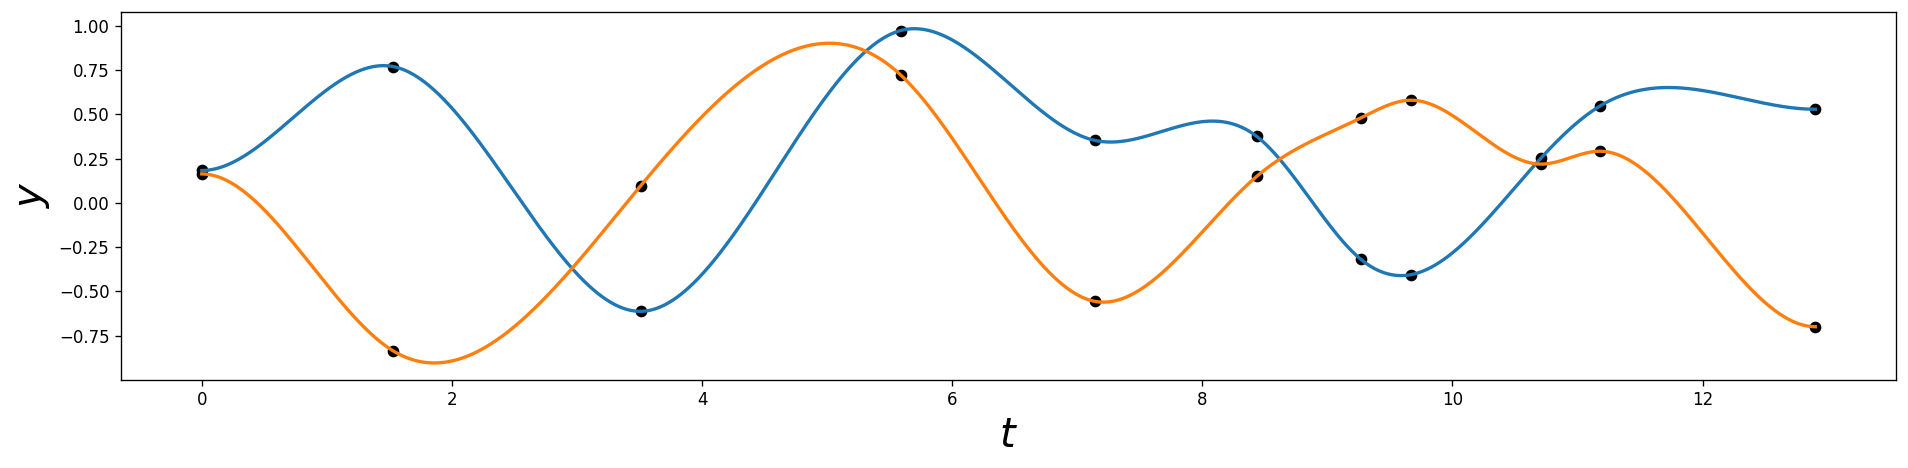

In [10]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$y$', fontsize=fontsize_)

plt.plot(t, y, lw=lw_)

for n in range(N+1):
    plt.scatter(np.sum(h[:n])*np.ones(ndof), y_nodes[n], color='k')
    
plt.tight_layout()
#plt.savefig("time_optimal_y.png")

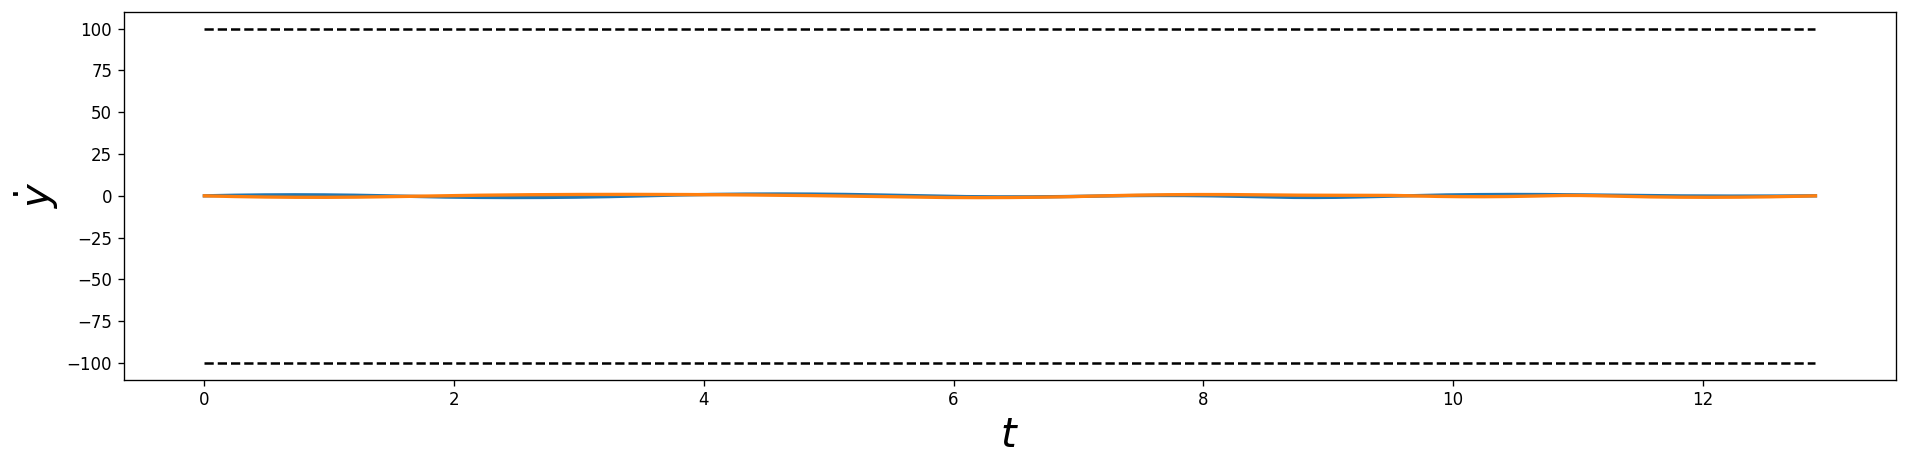

In [11]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\dot{y}$', fontsize=fontsize_)

plt.plot(t, dy, lw=lw_)

plt.plot([0,T], [dy_lim, dy_lim], 'k--')
plt.plot([0,T], [-dy_lim, -dy_lim], 'k--')

plt.tight_layout()
#plt.savefig("time_optimal_dy.png")

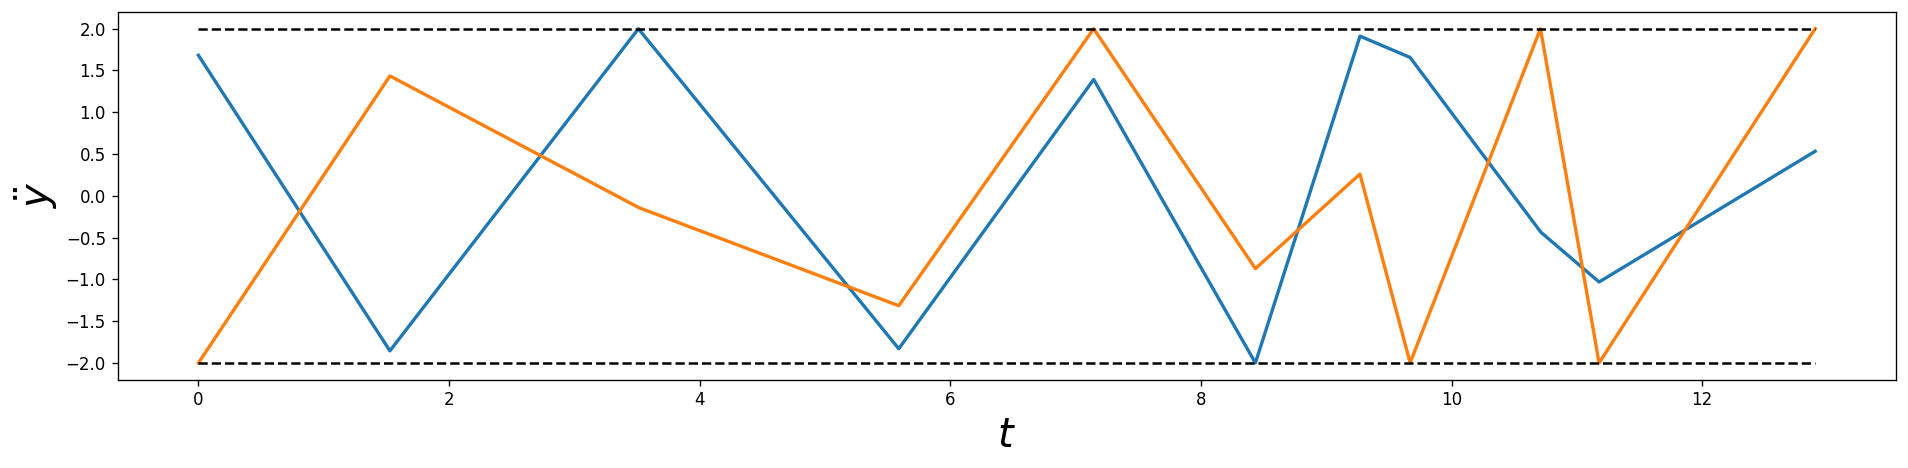

In [12]:
plt.figure(figsize=(16, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()

lw_ = 2
fontsize_ = 24

plt.xlabel(r'$t$', fontsize=fontsize_)
plt.ylabel(r'$\ddot{y}$', fontsize=fontsize_)

plt.plot(t, ddy, lw=lw_)

plt.plot([0,T], [ddy_lim, ddy_lim], 'k--')
plt.plot([0,T], [-ddy_lim, -ddy_lim], 'k--')

plt.tight_layout()
#plt.savefig("time_optimal_ddy.png")

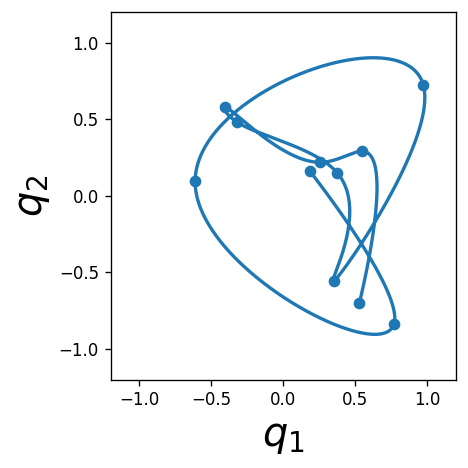

In [13]:
plt.figure(figsize=(4, 4), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])

lw_ = 2
fontsize_ = 24

plt.scatter(y_nodes[:,0], y_nodes[:,1])

plt.plot(y[:,0], y[:,1], lw=lw_)

plt.xlabel(r'$q_1$', fontsize=fontsize_)
plt.ylabel(r'$q_2$', fontsize=fontsize_)

plt.tight_layout()

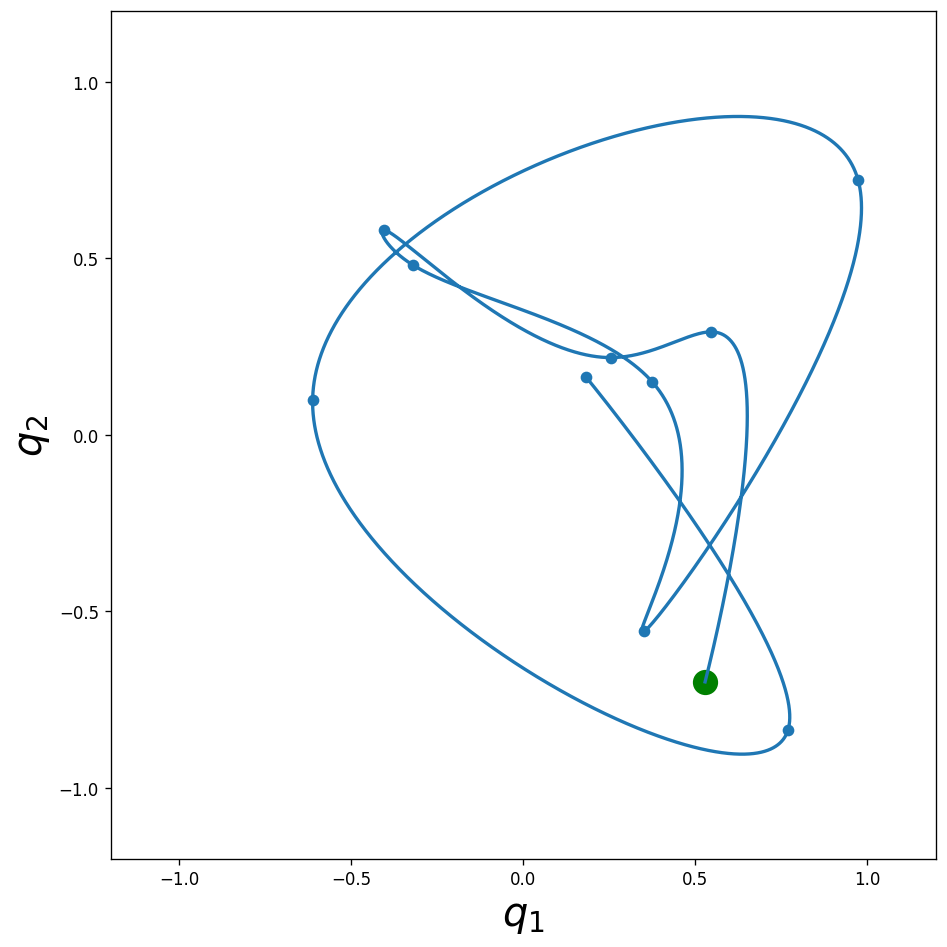

In [14]:
fig = plt.figure(figsize=(8, 8), dpi=120, facecolor='w', edgecolor='k')
ax = plt.axes()
ax.set_xlim([-1.2,1.2])
ax.set_ylim([-1.2,1.2])

lw_ = 2
fontsize_ = 24

plt.scatter(y_nodes[:,0], y_nodes[:,1])

plt.plot(y[:,0], y[:,1], lw=lw_)

plt.xlabel(r'$q_1$', fontsize=fontsize_)
plt.ylabel(r'$q_2$', fontsize=fontsize_)

plt.tight_layout()

robot_plot = ax.scatter(y[0,0], y[0,1], s=200, color='g')

dt_ani = 0.03
dt = 0.001
def animate(i_):
    i = int(i_*dt_ani/dt)
    robot_plot.set_offsets(y[i])
    return robot_plot, 

ani = animation.FuncAnimation(
    fig, animate, interval=dt_ani*1e3, blit=True, frames=int(T/dt_ani), repeat=False)

HTML(ani.to_html5_video())

In [15]:
from PyQt5 import QtWidgets, QtCore
from pyqtgraph import PlotWidget, plot
import pyqtgraph as pg
import sys  # We need sys so that we can pass argv to QApplication
import os
from random import randint

class MainWindow(QtWidgets.QMainWindow):
    def __init__(self, *args, **kwargs):
        super(MainWindow, self).__init__(*args, **kwargs)

        self.graphWidget = pg.PlotWidget()
        self.setCentralWidget(self.graphWidget)

        self.x = y[:,0]
        self.y = y[:,1]

        self.graphWidget.setBackground('w')

        pen = pg.mkPen(color=(255, 0, 0))
        self.data_line =  self.graphWidget.plot(self.x, self.y, pen=pen)


app = QtWidgets.QApplication(sys.argv)
w = MainWindow()
w.show()
app.exec_()

ImportError: cannot import name 'sip' from 'PyQt5' (/usr/lib/python3/dist-packages/PyQt5/__init__.py)